# Boron Doping Profiles

In [1]:
import numpy as np
from scipy import constants as sc
from matplotlib import pyplot as plt
from scipy.special import erf, erfc

In [2]:
Rp_b = 0.185 # um
ΔRp_b = 0.0526 # um
Δdist = 1e-3 # Δdist = space between each number = 0.001
interest_profile = np.arange(0, 1.0, Δdist) # um
background = 8.66e14

def init_boron(x):
    return 4.55e17 * np.exp(-(x - Rp_b)**2 / (2 * ΔRp_b**2))

## Initial

Text(0, 0.5, 'Concentration ($/cm^3$)')

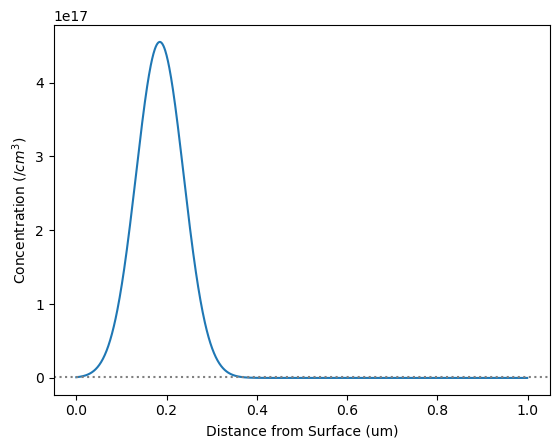

In [3]:
plt.plot(interest_profile, init_boron(interest_profile))
plt.axhline(y=background, label='background', linestyle=':', color='grey')
plt.xlabel('Distance from Surface (um)')
plt.ylabel('Concentration ($/cm^3$)')

In [4]:
def f2l(x, Δt, D, C):
    """
    The solution to Fick's 2nd law of diffusion.
    x = distance from source
    t = time elapsed
    D = diffusion constant
    C = concentration profile.
    
    returns ΔC(x, t) = the change in concentration at our distance x away from the source after t elapsed.
    """
    ΔC = D * np.gradient(np.gradient(C, x), x) * Δt
    return ΔC

def lim_src_diffusion(Q, D, t, x):
    """ returns the solution to limited source diffusion. """
    N0 = Q / np.sqrt(np.pi*D*t)
    return N0 * np.exp(-(x/2/np.sqrt(D*t))**2)

def const_src_diffusion(N0, D, t, x):
    """ returns the solution for constant source diffusion. """
    return N0 * erfc(x / 2 / np.sqrt(D*t))

In [5]:
def simulate(Ds, xs, t, x_arr, profile, n):
    """
    Ds = [D1, D2, ... Dn] = list of diffusivities, from lowest distance to surface
    xs = [x1, x2, ... xn] = list of distances that match diffusivities limit (left boundary). Therefore, x1=-infty always.
    t = time elapsed between simulation point
    x_arr = array of x depth values to match profile
    profile = concentrations at the various points in x_arr.
    n = number of times to simulate
    
    returns the new profile after simulating 1 step
    """
    new_profile = np.copy(profile)

    for _ in range(int(round(n))):
        for i, (D, x) in enumerate(zip(Ds, xs)):
            up_to = (x_arr <= xs[i+1]) if i < len(xs) - 1 else (x_arr < float('inf'))
            start_from = (x_arr > x)
            sim_range = np.logical_and(up_to, start_from)
            ΔC = f2l(x_arr[sim_range], t, D, new_profile[sim_range])
            new_profile[sim_range] += ΔC

    return new_profile

## Field Oxidation

In [6]:
initial_boron = init_boron(interest_profile)
D_si = 3e-14
D_sio2 = 2e-16

# convert to um
D_si *= (1e4)**2
D_sio2 *= (1e4**2)
print(D_si, D_sio2)

2.9999999999999997e-06 2e-08


In [7]:
def generate_oxide(sio2_thickness, initial, initial_interest):
    # obtain the profile of Boron dopants after growing SiO2 layer
    # initial_profile = np.copy(initial_boron)
    initial_profile = np.copy(initial)

    # sio2_thickness = 0.4679
    length_penetrated = sio2_thickness * 0.46
    length_out = sio2_thickness - length_penetrated

    new_top = initial_interest[0] - length_out

    # assumes that the boron that gets "pushed" by the SiO2 layer follows the segregation constant
    m_boron = 0.1 # segregation constant of Boron in Si/SiO2 interface.
    pushed = (initial_interest < length_penetrated)
    pushed_profile = initial[pushed]
    diff_profile = pushed_profile * m_boron
    initial_profile[pushed] -= diff_profile
    amount_pushed = np.trapz(diff_profile, initial_interest[pushed])
    
    # assumes all of the molecules pushed will undergo limited source diffusion
    # pushed_to = initial_interest[~pushed]
    # dist_pushed = pushed_to - pushed_to[0]
    # pushed_to_profile = lim_src_diffusion(amount_pushed, D_si, t, dist_pushed)
    #initial_profile[len(pushed_profile):] += pushed_to_profile
    # initial_profile[len(pushed_profile)] += amount_pushed / Δdist / len(pushed_profile)

    # the new oxide that grew on the top (excluding the oxide that pushed)
    new_interest_profile = np.concatenate((np.arange(new_top, 0.0, Δdist), initial_interest))
    new_initial_profile = np.zeros(np.shape(new_interest_profile))
    new_initial_profile[-len(initial_profile):] = initial_profile

    # plt.plot(new_interest_profile, new_initial_profile)
    # plt.plot(interest_profile, init_boron(interest_profile))
    return (new_interest_profile, new_initial_profile)

fox_thickness = 0.4679
fox_length_penetrated = 0.46 * fox_thickness
new_interest_profile, new_initial_profile = generate_oxide(fox_thickness, initial_boron, interest_profile)

In [8]:
new = np.copy(new_initial_profile)
Δt = 0.1
tot_time = 95 * 60
Ds = [D_sio2, D_si]
ls = [float('-inf'), fox_length_penetrated]
new = simulate(Ds, ls, Δt, new_interest_profile, new, tot_time / Δt)

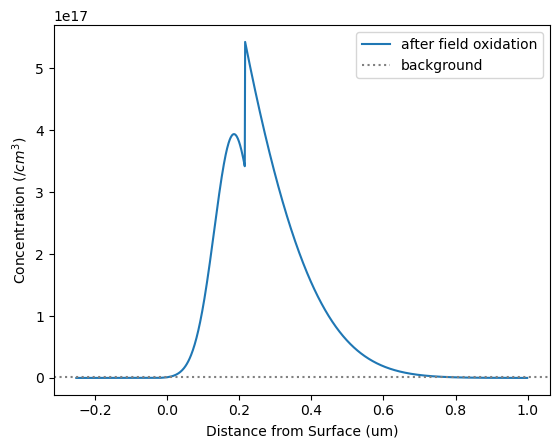

In [9]:
# plt.plot(interest_profile, initial_boron, linestyle=':', color='black', label='initial boron')
# plt.plot(new_interest_profile, new_initial_profile)
plt.plot(new_interest_profile, new, label='after field oxidation')
plt.axhline(y=background, label='background', linestyle=':', color='grey')
# plt.axvline(x=length_penetrated, linestyle=':', color='grey')
plt.xlabel('Distance from Surface (um)')
plt.ylabel('Concentration ($/cm^3$)')
plt.legend()
plt.savefig('fieldoxide_profile.jpg', dpi=720, bbox_inches='tight')

In [10]:
dosage_fox = np.trapz(new, new_interest_profile * 1e-4)
dosage_fox

11303588121680.566

## Gate Oxide

0.042274


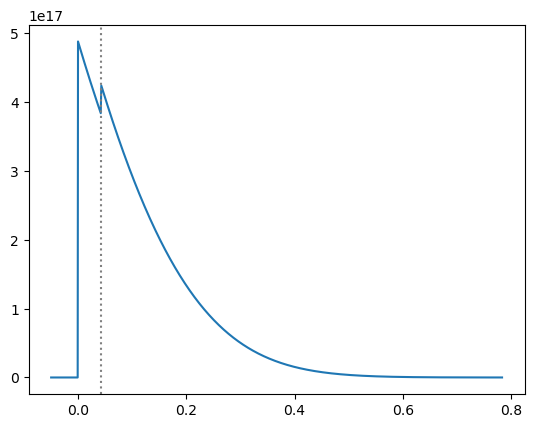

In [11]:
gate_init = np.copy(new)

# strip off the SiO2 layer.
gate_init[new_interest_profile < fox_length_penetrated] = 0
gate_init = gate_init[new_interest_profile > fox_length_penetrated]
gate_init_interest = np.copy(new_interest_profile[new_interest_profile > fox_length_penetrated])

# reset so the surface corresponds to x=0.0
gate_init_interest -= gate_init_interest[0]

gate_thickness = 0.0919
gate_interest_profile, gate_initial_profile = generate_oxide(gate_thickness, gate_init, gate_init_interest)

gate_length_penetrated = 0.0919 * 0.46
print(gate_length_penetrated)
plt.plot(gate_interest_profile, gate_initial_profile)
plt.axvline(x=gate_length_penetrated, linestyle=':', color='grey')

In [12]:
new_gate = np.copy(gate_initial_profile)
gate_time = 45 * 60
D_sio2_dry = 5.16e-2 * np.exp(-4.06 / (1100+273) / sc.k * sc.eV)
print(D_sio2_dry)
D_sio2_dry *= 1e4**2
new_gate = simulate([D_sio2_dry, D_si], [float('-inf'), gate_length_penetrated], Δt, gate_interest_profile, new_gate, gate_time / Δt)

6.454794985317141e-17


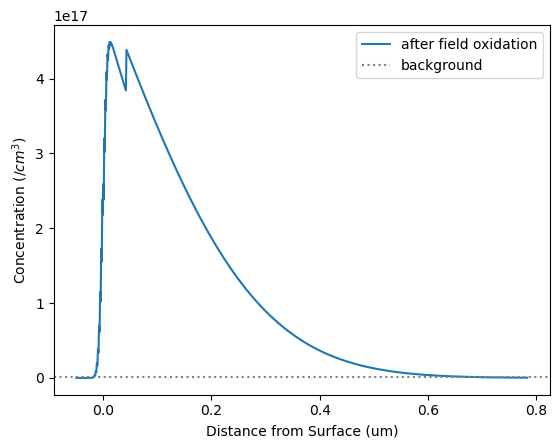

In [13]:
# plt.plot(gate_interest_profile, gate_initial_profile, linestyle=':', color='black', label='boron after ACTV etching')
plt.plot(gate_interest_profile, new_gate, label='after field oxidation')
plt.axhline(y=background, label='background', linestyle=':', color='grey')
# plt.axvline(x=length_penetrated, linestyle=':', color='grey')
plt.xlabel('Distance from Surface (um)')
plt.ylabel('Concentration ($/cm^3$)')
plt.legend()
plt.savefig('gateoxide_profile.jpg', dpi=720, bbox_inches='tight')

In [14]:
def find_junction(xs, profile):
    signchanges = (np.diff(np.sign(profile - background)) != 0)
    signchanges = np.append(signchanges, False)
    return xs[signchanges]

xjs_gate = find_junction(gate_interest_profile, new_gate)[1]
print(xjs_gate)

0.7070000000000001


In [15]:
# dosage boron
junc_gate = new_gate[gate_interest_profile < xjs_gate]
junc_gate_interest = gate_interest_profile[gate_interest_profile < xjs_gate]
dosage_gate = np.trapz(junc_gate, junc_gate_interest * 1e-4)
print(dosage_gate)

diff = dosage_fox - dosage_gate # amount "chopped" off from the beginning
dosage_boron_at_gate = 6.0e12 - diff
dosage_boron_at_gate

8917137841972.418


3613549720291.8516

## Phosphorus Doping

In [16]:
N0_P = 4e20
D_P = 1e-13 * 1e4 ** 2
t = 10 * 60

P_interest = np.arange(0, 1, Δdist)
P_profile = const_src_diffusion(N0_P, D_P, t, P_interest)

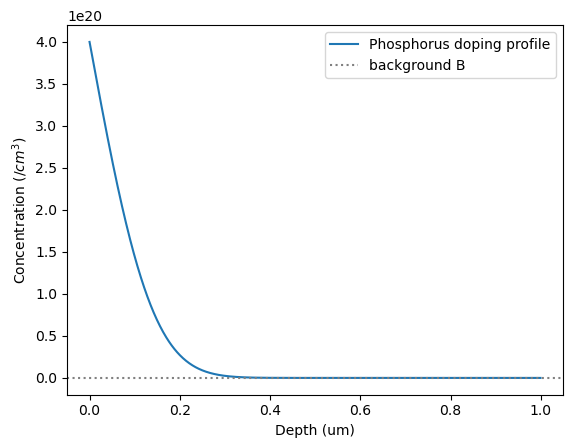

In [17]:
plt.plot(P_interest, P_profile, label='Phosphorus doping profile')
plt.axhline(y=background, label='background B', linestyle=':', color='grey')
plt.ylabel('Concentration ($/cm^3$)')
plt.xlabel('Depth (um)')
plt.legend()
plt.savefig('phosphorus_doping.jpg', dpi=720, bbox_inches='tight')


In [18]:
# dopant dosage phosphorus
np.trapz(P_profile, P_interest * 1e-4)

3496179256782387.5

0.039743999999999995 0.033856000000000004


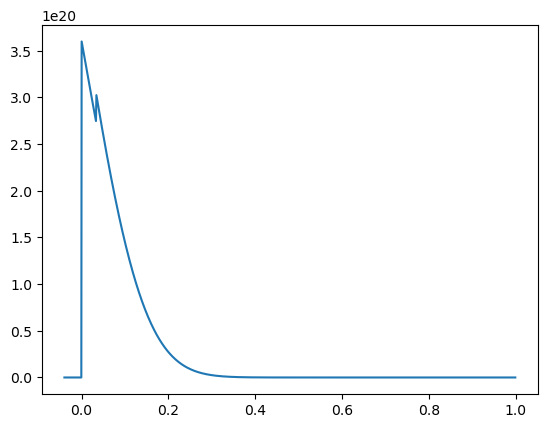

In [25]:
intr_thickness = 73.6e-3
intr_penetrated = intr_thickness * 0.46
intr_out = intr_thickness - intr_penetrated
print(intr_out, intr_penetrated)

new_p_interest, new_p_profile = generate_oxide(intr_thickness, P_profile, P_interest)
plt.plot(new_p_interest, new_p_profile)

In [20]:
D_phos = [D_sio2, D_si]
l_phos = [float('-inf'), intr_penetrated]

intr_p_profile = simulate(D_phos, l_phos, Δt, new_p_interest, new_p_profile, 37 * 60 / Δt)

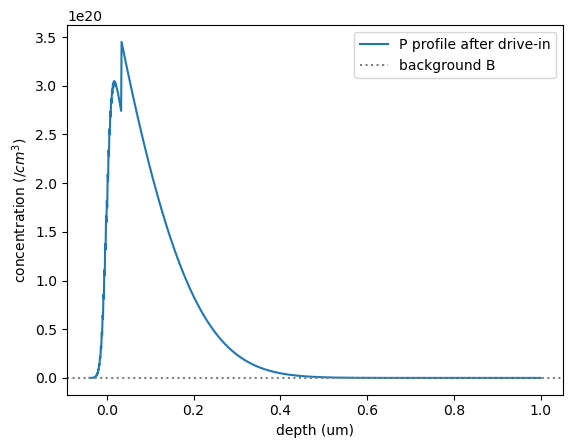

In [21]:
plt.plot(new_p_interest, intr_p_profile, label='P profile after drive-in')
plt.axhline(y=background, label='background B', linestyle=':', color='grey')
# plt.plot(new_p_interest, new_p_profile, linestyle=':')
plt.xlabel('depth (um)')
plt.ylabel('concentration ($/cm^3$)')
plt.legend()
plt.savefig('p_drivein_profile.jpg', dpi=720, bbox_inches='tight')

In [22]:
xjs_p = find_junction(new_p_interest, intr_p_profile)
xjs_p

array([0.753])

In [23]:
# strip off sio2.
new_p_profile[new_p_interest < intr_penetrated] = 0
p_dose = np.trapz(new_p_profile[new_p_interest < xjs_p[0]], new_p_interest[new_p_interest < xjs_p[0]] * 1e-4)
p_dose

2318362794576105.5